In [104]:
import matplotlib.pyplot as plt
import pyGMs as gm
import numpy as np
import torch
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
import pyro.poutine as poutine

import random
import pandas as pd

seed = 123
pyro.set_rng_seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

(array([ 0.,  0.,  0.,  1.,  1., 11.,  6., 22., 14., 17., 15., 17.,  6.,
        10., 12.,  9.,  7., 11.]),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.]),
 <BarContainer object of 18 artists>)

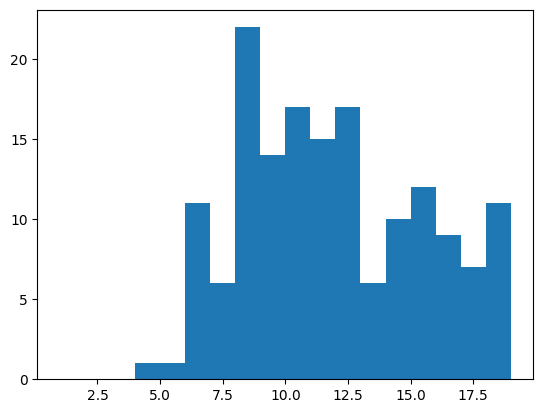

In [115]:
golden_sample = torch.load('mcmc_samples_20000.pt')
dataset = torch.load("dataset.pt")
teams = torch.load("teams.pt")
teams_number = list(range(len(teams)))


# dataset = random.sample(dataset, len(dataset) // 1)

team_games = {}
for winner, loser, _ in dataset:
    team_games[winner] = team_games.get(winner, 0) + 1
    team_games[loser] = team_games.get(loser, 0) + 1

plt.hist(list(team_games.values()), bins=range(1, 20))

In [118]:
len(dataset) / (len(teams) + 1) ** 2 / 2

0.017583819241982507

In [106]:
def construct_ranking(samples: dict, teams) -> dict:
    return {
        team: rank for rank, team in enumerate(
            sorted(teams,
                   key=lambda i: samples[f"X{i}"].mean(), reverse=True)
        )
    }


def model(matches, n_teams):
    X = [pyro.sample(f"X{i}", dist.Normal(0, 1)) for i in range(n_teams)]

    for i, m in enumerate(matches):
        pyro.sample(f"w{i}",
                    dist.Bernoulli(logits=X[m[0]]-X[m[1]]),
                    obs=torch.tensor(1.))

In [107]:
mcmc_runs = []

for n in [1, 5, 10, 50, 100, 200]:
    nuts_kernel = pyro.infer.NUTS(model, jit_compile=False)
    mcmc = pyro.infer.MCMC(nuts_kernel, num_samples=n,
                           warmup_steps=20, num_chains=1)
    mcmc.run(dataset, len(teams))

    mcmc_runs.append((n, mcmc.get_samples()))

Sample: 100%|██████████| 220/220 [03:05,  1.19it/s, step size=8.91e-01, acc. prob=0.133]


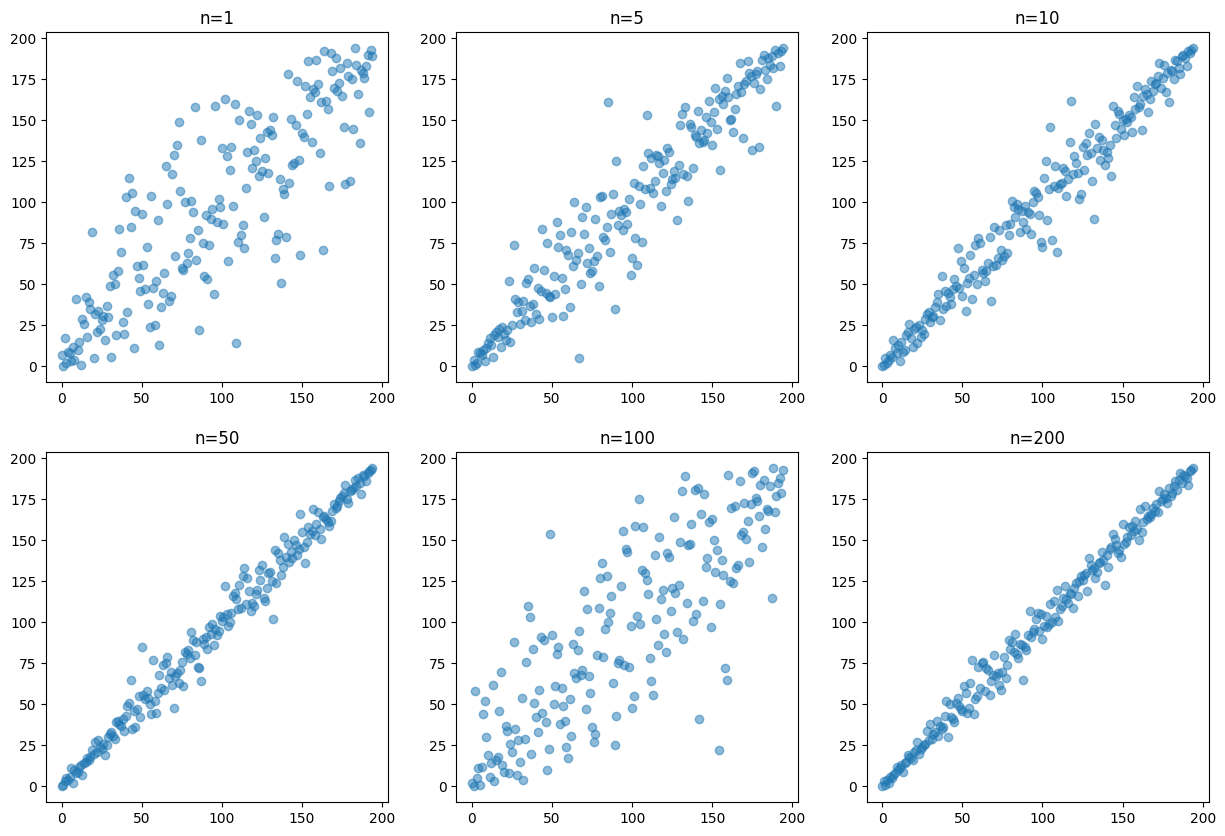

In [109]:
golden_ranking = construct_ranking(golden_sample, teams_number)

X = [golden_ranking[i] for i in teams_number]

# plot results in a subplot grid
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, (n, samples) in enumerate(mcmc_runs):
    ranking = construct_ranking(samples, teams_number)
    Y = [ranking[i] for i in teams_number]

    ax = axs[i//3, i % 3]
    ax.plot(X, Y, 'o', alpha=0.5)
    ax.set_title(f"n={n}")

# Saved results from original full dataset

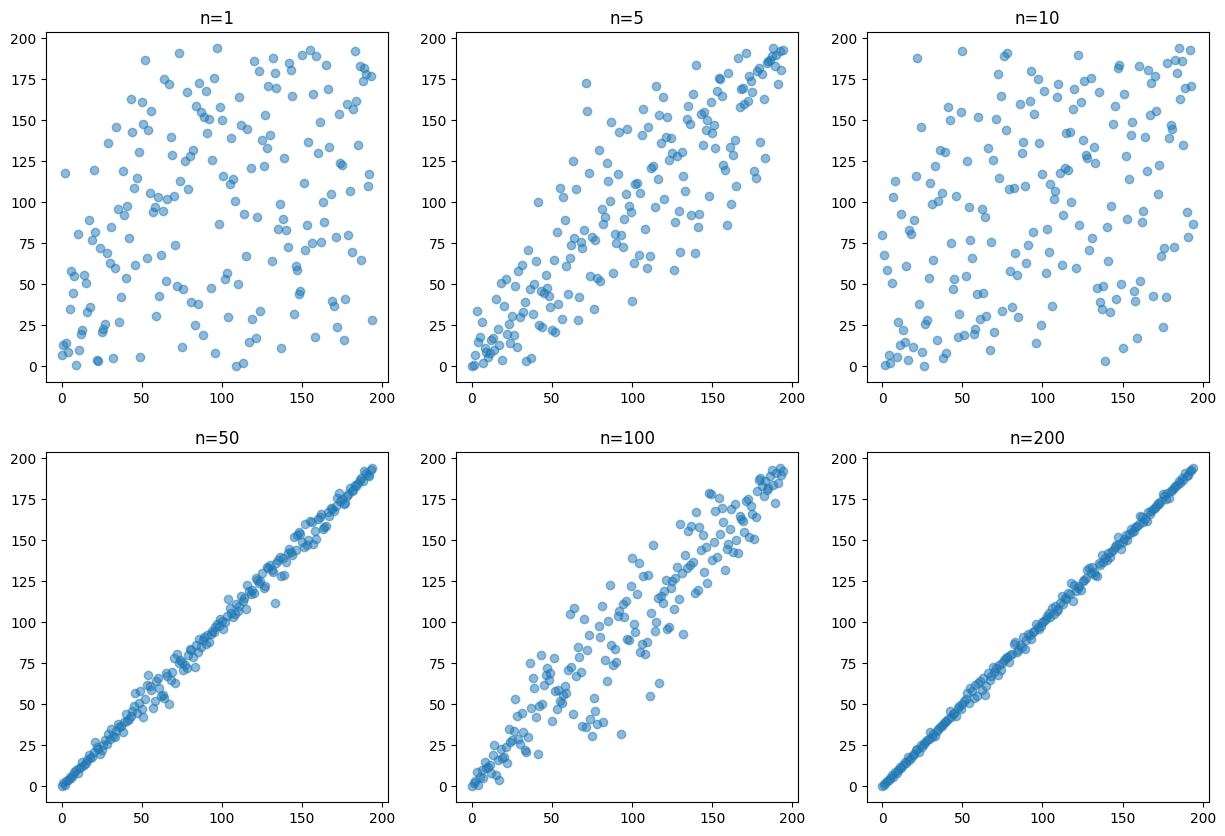

In [73]:
golden_ranking = construct_ranking(golden_sample, teams_number)

X = [golden_ranking[i] for i in teams_number]

# plot results in a subplot grid
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

for i, (n, samples) in enumerate(mcmc_runs):
    ranking = construct_ranking(samples, teams_number)
    Y = [ranking[i] for i in teams_number]

    ax = axs[i//3, i % 3]
    ax.plot(X, Y, 'o', alpha=0.5)
    ax.set_title(f"n={n}")

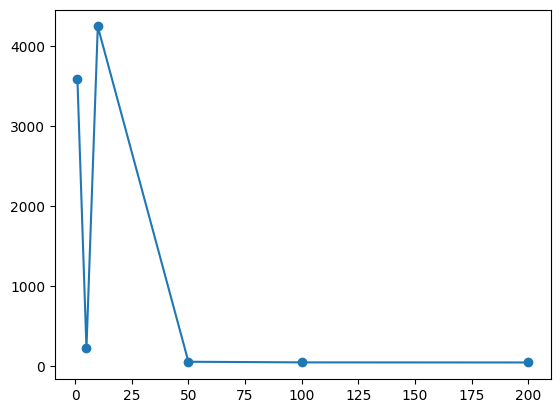

In [68]:
# graph n vs mse
mses = []
for n, samples in mcmc_runs:
    ranking = construct_ranking(samples, teams_number)
    Y = [ranking[i] for i in teams_number]
    mses.append(np.mean((np.array(X) - np.array(Y))**2))

plt.plot([n for n, _ in mcmc_runs], mses, 'o-')